# MINE 4101 Ciencia de datos aplicados - Modelos para predecir complicaciones

Como parte del proyecto desarrollado para el Servicio de Cirugía Hepatobiliar y de Transplantes de la Fundación Santafe se realizará un análisis de qué variables pueden llevar a que se presenten complicaciones posquirúrgicas

# Importación de librerías y funciones auxiliares

In [292]:
import mlflow
import mlflow.sklearn

In [293]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
import lime
import lime.lime_tabular
import shap

In [419]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Preparación de los datos

In [295]:
df = pd.read_excel('../Trasplante hepático consolidado - Complicación imputada.xlsx')

In [296]:
df.sample(3)

,#_Paciente,Año_Tx,Mes_Tx#1,Edad_Al_Tx,Tiempo_En_Lista_Días,Tiempo_En_Lista_Meses,Tiempo_En_Lista_Años,Sexo_Receptor,EPS,Causa_1_Tx_Hepático_,...,EKG_VALOR_POP_1,EKG_VALOR_POP_categoria,Retrasplante_bool,Indicación_Retrasplante_categoria,Fecha_Tx#2,Indicación_Retrasplante_categoria.1,Grado_HCC_desc,Sobrevida_Días_calculado,Causa_De_Muerte_categoria,Código de anonimización
353,354,2014,6,48.405479,453.0,15.100000,1.258333,MUJER,SANITAS,OVERLAP (CBP + AIH),...,NaN,NaN,0.0,NaN,NaT,NaN,NaN,3848.0,NaN,TXHEP354
64,65,2005,8,48.663014,67.0,2.233333,0.186111,MUJER,SANITAS,HEPATITIS AUTOINMUNE,...,NaN,NaN,0.0,NaN,NaT,NaN,NaN,7074.0,NaN,TXHEP065
597,598,2021,1,27.600000,816.0,27.200000,2.266667,HOMBRE,COMPENSAR,COLANGITIS BILIAR PRIMARIA,...,0.0,Normal,0.0,NaN,NaT,NaN,NaN,1458.0,NaN,TXHEP598


## Selección de variables a usar

In [297]:
# Seleccionamos las columnas que no necesitan modificaciones adicionales
num_cols = [
    'Edad_Al_Tx',
    'Tiempo_En_Lista_Días',
    'Peso_Pre_Tx',
    'MELD_Score',
    'Colesterol_TotalPre_Tx',
    'LDL_Pre_Tx',
    'HDL_Pre_Tx',
    'Triglicéridos_Pre_Tx',
    'Ecocardiograma_PreQx_FE%',
    'Ecocardiograma_PreQx_RC%',
    'Ecocardiograma_PreQx_TAPSE',
    'Ecocardiograma_PreQx_TASVE',
    'METS',
    'Edad_Donante_Tx#1',
    '#_Unidades_Glóbulos_Rojos_Tx#1',
    '#_Unidades_Plasma_Fresco_Congelado_Tx#1',
    '#_Unidades_Crioprecipitados_Tx#1',
    '#_Unidades_Plaquetas_Tx#1',
    'Tiempo_Quirúrgico_Tx#1',
    'Días_Tratamiento_Antibiótico_Previo_A_Tx#1',
    'Tiempo_De_Dosis_Hasta_Tx#1',
    'Tiempo_Sonda_Vesical',
    'Tiempo_CVC',
    'Días_de_Profilaxis_Antitrombótica',
    'Días_En_UCI',
    'Días_En_Hospitalización_Piso',
    'Días_Totales_Intrahospitalarios',
    'Ecocardiograma_POP_FE%',
    'Ecocardiograma_POP_PASP',
    'Días_Desde_Tx#1',
    'Grado_HCC',
    'αFP_PreTx',
    'αFP_Al_Dx',
    'Tiempo_Isquemia_Fría_Tx#1',
    'Diámetro_Nódulo_Principal_(cm)_Al_Dx',
    'Ki67',
    '#_Nódulos_Al_Dx',

    ]
ord_cols = [
    'Composición_Corporal',
]
bool_cols = [
    'Hepatocarcinoma',
    'Falla_Cardiaca_Pre_Tx',
    'Antecedente_De_Tabaquismo',
    'Antecedente_De_Alcoholismo',
    'Enfermedad_Coronaria_Pre_Tx',
    'Infarto_Cardiaco_Pre_Tx',
    'Diabetes_Mellitus_Pre_Tx',
    'Hipertensión_Arterial_Pre_Tx',
    'CMV_Receptor',
    'Ecocardiograma_PreQx_RC',
    'Ecocardiograma_PreQx_Hipertensión_Pulmonar',
    'Ecocardiograma_PreQx_Disfunción_Diastólica',
    'Trasplante_Combinado-Hígado-Riñón_Tx#1',
    'Antibiótico_Profiláctico_VS_Terapéutico',
    'Soporte_Vasopresor_PeriTx',
    'Levosimendan_PeriTx',
    'Noradrenalina_PeriTx',
    'Adrenalina_PeriTx',
    'Vasopresina_PeriTx',
    'Dopamina_PeriTx',
    'Amiodarona_PeriTx',
    'Stent',
    'Requirió_Reconstrucción_Biliar',
    'Profilaxis_Antitrombótica',
    'Fast_Track',
    'Rechazo_Agudo',
    'Rechazo_Crónico',
    'Retrasplante',
    'PTLD',
    'Trombosis_Porta_Tumoral',
    'Sobrevida_PeriQx_30_días_POP',
    ]

df_model = df[num_cols + ord_cols + bool_cols]

In [298]:
df['Inmunosupresión_con_Anticuerpos'].value_counts()

Inmunosupresión_con_Anticuerpos
NO    172
SI     56
Name: count, dtype: int64

### Sexo del paciente

In [299]:
df_model['Es_Mujer'] = df['Sexo_Receptor'].replace({
    'HOMBRE': 0,
    'MUJER' : 1
})
bool_cols.append('Es_Mujer')

C:\Users\jmriv\AppData\Local\Temp\ipykernel_19952\2412035747.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['Es_Mujer'] = df['Sexo_Receptor'].replace({
C:\Users\jmriv\AppData\Local\Temp\ipykernel_19952\2412035747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Es_Mujer'] = df['Sexo_Receptor'].replace({


### Causa del transplante

In [300]:
mlb = MultiLabelBinarizer()
df_causas = df[['Causa_1_Tx_Hepático_', 'Causa_2_Tx_Hepático_']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [301]:
encoded_df = encoded_df.add_prefix("Causa_Tx_")

In [302]:
bool_cols += encoded_df.columns.to_list()

In [303]:
df_model = pd.concat([df_model, encoded_df], axis=1)

### Child Pugh
La variable tiene caracter ordinal, por lo que se codificará de 0 a 3

In [304]:
df_model['Child_Pugh_Letra'] = df['Child_Pugh_Letra'].replace({
    np.nan : 0,
    'A' : 1,
    'B' : 2,
    'C' : 3
})
ord_cols.append('Child_Pugh_Letra')
df_model['Child_Pugh_Letra'].value_counts()

C:\Users\jmriv\AppData\Local\Temp\ipykernel_19952\3468525605.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['Child_Pugh_Letra'] = df['Child_Pugh_Letra'].replace({


Child_Pugh_Letra
2    370
3    179
1    131
0     56
Name: count, dtype: int64

### Causa transplante renal

In [305]:
mlb = MultiLabelBinarizer()
df_causas = df[['Causa_Tx_Renal']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [306]:
encoded_df = encoded_df.add_prefix("Causa_Tx_Renal_")

In [307]:
bool_cols += encoded_df.columns.to_list()

In [308]:
df_model = pd.concat([df_model, encoded_df], axis=1)

### Antecedente de dislipidemia

In [309]:
df['Dislipidemia_Pre_Tx'] = df['Dislipidemia_Pre_Tx'].replace( {
    0:"NO",
    1:"HIPERCOLESTEROLISMO",
    2:"HIPERTRIGLICERIDEMIA",
    3:"HIPERLIPIDEMIA MIXTA",
    4:"DÉFICIT DE HDL",
})

In [310]:
mlb = MultiLabelBinarizer()
df_causas = df[['Dislipidemia_Pre_Tx']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [311]:
encoded_df = encoded_df.add_prefix("Dislipidemia_Pre_Tx_")

In [312]:
bool_cols += encoded_df.columns.to_list()

In [313]:
df_model = pd.concat([df_model, encoded_df], axis=1)

### Afectación renal en función del MDRD

In [314]:
df['MDRD_Categórico_PreTx'] = df['MDRD_Categórico_PreTx'].replace( {
    0:" > 90",
    1:" 90-60",
    2:" 59-30",
    3:" 15-29",
    4:"< 15",
})

In [315]:
mlb = MultiLabelBinarizer()
df_causas = df[['MDRD_Categórico_PreTx']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [316]:
encoded_df = encoded_df.add_prefix("MDRD_PreTx_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Ecocardiograma pre Tx

In [317]:
df['EKG_PreQx'] = df['EKG_PreQx'].replace( {
    0:"Normal",
    1:"QTc prolongado ",
    2:"Trastornos de la repolarizacion",
    3:"Taquiarritmias supraventriculares",
    4:"Taquiarritmias ventriculares",
    5:"Bradiarritmias",
    6:"Extrasistoles",
    7:"Mala prog Onda R",
    8:"Bloqueo Rama Der",
    9:"Bloqueo Rama Izq",
})

In [318]:
mlb = MultiLabelBinarizer()
df_causas = df[['EKG_PreQx']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [319]:
encoded_df = encoded_df.add_prefix("EKG_PreQx_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Valvulopatía pre TX

In [320]:
df['Valvulopatía_Pre_Tx'] = df['Valvulopatía_Pre_Tx'].astype(str).str.split('|')

In [321]:
df['Valvulopatía_Pre_Tx'] = df['Valvulopatía_Pre_Tx'].apply(
    lambda x: x if x != ['nan'] else []
)

In [322]:
mlb = MultiLabelBinarizer()
encoded = mlb.fit_transform(df['Valvulopatía_Pre_Tx'])
encoded_df = pd.DataFrame(encoded, columns=mlb.classes_)

In [323]:
encoded_df = encoded_df.rename(columns ={
    '0':"NO",
    '1':"AÓRTICA",
    '2':"MITRAL",
    '3':"PULMONAR",
    '4':"TRICUSPÍDEA",
})
encoded_df = encoded_df.add_prefix("Valvulopatía_Pre_Tx_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### CÓDIGO FRACCIÓN DE EYECCIÓN EN ECOCARDIOGRAMA

In [324]:
df['Ecocardiograma_PreQx-FE_Cod'] = df['Ecocardiograma_PreQx-FE_Cod'].replace(
    {
    0:">60%",
    1:"40-60%",
    2:"< 40%",
}
)

In [325]:
mlb = MultiLabelBinarizer()
df_causas = df[['Ecocardiograma_PreQx-FE_Cod']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [326]:
encoded_df = encoded_df.add_prefix("Ecocardiograma_PreQx-FE_Cod_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Sexo donante

In [327]:
df_model['Donante_es_mujer'] = df['Sexo_Donante_Tx#1'].replace(
    {
    1: 0,
    2: 1
    }
    )

### Causa de muerte del donante

In [328]:
df['Causa_Muerte_Donante_Tx#1'] = df['Causa_Muerte_Donante_Tx#1'].replace(
    {
    1:"TCE",
    2:"ACV",
    3:"HERIDA CUELLO",
    4:"HIPÓXICA",
    5:"HERIDA X ARMA  DE FUEGO",
    6:"POST-CLIPAJE ANEURISMA",
    7:"RUPTURA ANEURISMA",
    8:"TRAUMA RAQUIMEDULAR",
    9:"RESECCION DE MENINGIOMA",
    10:"HEMORRAGIA SUBARACNOIDEA",
    11:"ADENOMA DE HIPOFISIS",
    12:"HIPERTENSION ENDOCRANEANA",
    13:"STATUS CONVULSIVO",
    14:"PARO CARDIORESPIRATORIO DE ORIGEN NO CLARO",
    15:"OTRO TUMOR CEREBRAL",
    }
    )

In [329]:
mlb = MultiLabelBinarizer()
df_causas = df[['Causa_Muerte_Donante_Tx#1']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [330]:
encoded_df = encoded_df.add_prefix("Causa_Muerte_Donante_Tx#1_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Tipo de cirujía

In [331]:
df['Tipo_de_Cx-Trasplante_Tx#1'] = df['Tipo_de_Cx-Trasplante_Tx#1'].replace(
    {
    1:"BYPASS",
    2:"PIGGY-BACK",
    3:"CROSS-CLAMPING",
    4:"SPLIT",
    }
    )

In [332]:
mlb = MultiLabelBinarizer()
df_causas = df[['Tipo_de_Cx-Trasplante_Tx#1']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])


In [333]:
encoded_df = encoded_df.add_prefix("Tipo_de_Cx-Trasplante_Tx#1_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Severidad Rechazo Agudo

In [334]:
df['Severidad_Rechazo_Agudo'] = df['Severidad_Rechazo_Agudo'].replace(
    {
    0:"NO",
    1:"LEVE",
    2:"MODERADO",
    3:"SEVERO",
    4:"BORDERLINE",
    }
    )

In [335]:
mlb = MultiLabelBinarizer()
df_causas = df[['Severidad_Rechazo_Agudo']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [336]:
encoded_df = encoded_df.add_prefix("Severidad_Rechazo_Agudo_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Indicación retransplante

In [337]:
df['Indicación_Retrasplante'] = df['Indicación_Retrasplante'].replace(
    {
    1:"DISFUNCIÓN PRIMARIA DEL INJERTO ",
    2:"TROMBOSIS ARTERIA HEPÁTICA",
    3:"TROMBOSIS PORTAL",
    4:"BUDD CHIARI",
    5:"COLANGIOPATIA ISQUEMICA",
    6:"HELLP",
    }
    )

In [338]:
mlb = MultiLabelBinarizer()
df_causas = df[['Indicación_Retrasplante']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])


In [339]:
encoded_df = encoded_df.add_prefix("Indicación_Retrasplante_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Neoplasia Post Cx

In [340]:
mlb = MultiLabelBinarizer()
df_causas = df[['Neoplasia_PostTx']].astype(str)
X = mlb.fit_transform(df_causas.values.tolist())

encoded_df = pd.DataFrame(X, columns=mlb.classes_)
encoded_df = encoded_df.drop(columns=['nan'])

In [341]:
encoded_df = encoded_df.add_prefix("Neoplasia_PostTx_")
bool_cols += encoded_df.columns.to_list()
df_model = pd.concat([df_model, encoded_df], axis=1)

### Estadio

In [342]:
df_model['Estadio'] = df['Estadio'].replace(
    {
    "ESTADIO 1":1,
    "ESTADIO 2":2,
    "ESTADIO 3":3,
    "ESTADIO 4":4,
    }
    )

C:\Users\jmriv\AppData\Local\Temp\ipykernel_19952\343527641.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['Estadio'] = df['Estadio'].replace(


### Complicación

In [392]:
df_model['¿Complicación?'] = df['¿Complicación?']

## Revisión de nulos

In [442]:
df['¿Complicación?'].value_counts()

¿Complicación?
1.0    410
0.0    268
Name: count, dtype: int64

In [393]:
null_percent = df_model.isnull().mean().sort_values(ascending=False)

In [394]:
threshold = 0.16
cols_to_drop = null_percent[null_percent > threshold].index
cols_to_drop

Index(['Ecocardiograma_POP_PASP', 'Días_Desde_Tx#1', 'Ki67', 'METS',
       'Grado_HCC', 'Estadio', 'Diámetro_Nódulo_Principal_(cm)_Al_Dx',
       'Ecocardiograma_POP_FE%', '#_Nódulos_Al_Dx',
       'Ecocardiograma_PreQx_TASVE', 'αFP_PreTx', 'Trombosis_Porta_Tumoral',
       'αFP_Al_Dx', 'Ecocardiograma_PreQx_Hipertensión_Pulmonar',
       'Ecocardiograma_PreQx_TAPSE', 'Tiempo_Sonda_Vesical', 'Tiempo_CVC',
       'Ecocardiograma_PreQx_RC', 'LDL_Pre_Tx', 'HDL_Pre_Tx',
       'Días_de_Profilaxis_Antitrombótica', 'Triglicéridos_Pre_Tx',
       'Tiempo_De_Dosis_Hasta_Tx#1', 'Ecocardiograma_PreQx_RC%',
       'Ecocardiograma_PreQx_Disfunción_Diastólica',
       'Profilaxis_Antitrombótica', 'Colesterol_TotalPre_Tx',
       'Ecocardiograma_PreQx_FE%',
       'Días_Tratamiento_Antibiótico_Previo_A_Tx#1',
       'Antibiótico_Profiláctico_VS_Terapéutico'],
      dtype='object')

In [395]:
df_filtered = df_model.drop(columns = cols_to_drop)
df_filtered

,Edad_Al_Tx,Tiempo_En_Lista_Días,Peso_Pre_Tx,MELD_Score,Edad_Donante_Tx#1,#_Unidades_Glóbulos_Rojos_Tx#1,#_Unidades_Plasma_Fresco_Congelado_Tx#1,#_Unidades_Crioprecipitados_Tx#1,#_Unidades_Plaquetas_Tx#1,Tiempo_Quirúrgico_Tx#1,...,Indicación_Retrasplante_TROMBOSIS PORTAL,Neoplasia_PostTx_CA PIEL,Neoplasia_PostTx_CA PULMON,Neoplasia_PostTx_CA RENAL,Neoplasia_PostTx_CA SENO,Neoplasia_PostTx_CA UTERO,Neoplasia_PostTx_NO,Neoplasia_PostTx_PTLD,Neoplasia_PostTx_SARCOMA DE KAPOSI,¿Complicación?
0,14.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
1,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
2,28.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
3,27.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
4,37.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,68.00,15.0,67.0,17.0,30.0,2.0,6.0,0.0,6.0,4.45,...,0,0,0,0,0,0,0,1,0,0.0
732,56.00,205.0,53.0,8.0,55.0,4.0,2.0,0.0,1.0,4.30,...,0,0,0,0,0,0,1,0,0,0.0
733,43.00,45740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN
734,55.00,45743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,NaN


In [397]:
df_filtered = df_filtered.dropna()
print(df_filtered.shape)

(466, 143)


# Entrenamiento de los modelos

Separamos los datos en un conjunto para entrenamiento y otro para validación. Usamos un muestreo estratificado para mantener la proporción de la variable objetivo

In [411]:
X = df_filtered.drop(columns='¿Complicación?')
y = df_filtered['¿Complicación?']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [418]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Regresión logística

In [ ]:
# 10 minutos
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'l1_ratio': [0.0, 0.5, 1.0]
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=5000), param_grid=params, cv=cv, scoring='f1_weighted', verbose=3, n_jobs=-1)
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_
print("Mejor regresión logística: ", grid_lr.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


NameError: name 'grid_rf' is not defined

In [401]:
print("Mejor regresión logística: ", grid_lr.best_params_)

Mejor regresión logística:  {'C': 0.01, 'l1_ratio': 0.0, 'penalty': 'l2', 'solver': 'lbfgs'}


In [412]:
y_pred = best_lr.predict(X_val)

In [415]:
print(classification_report(y_val, y_pred,target_names=["Sin complicaciones", "Con complicaciones"]))

                    precision    recall  f1-score   support

Sin complicaciones       0.58      0.56      0.57        59
Con complicaciones       0.69      0.70      0.70        81

          accuracy                           0.64       140
         macro avg       0.63      0.63      0.63       140
      weighted avg       0.64      0.64      0.64       140



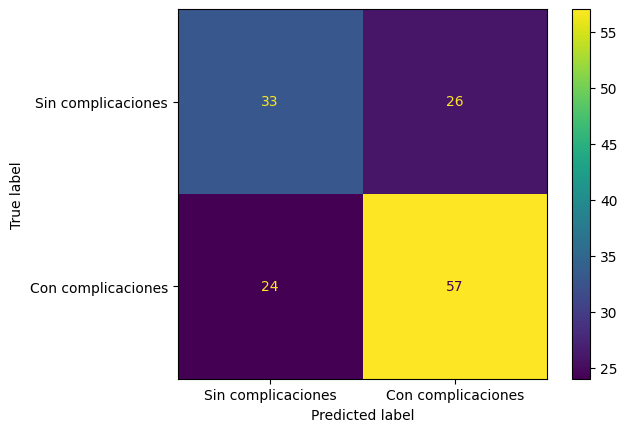

In [417]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=["Sin complicaciones", "Con complicaciones"])
plt.show()

## Árbol de decisión

In [422]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'class_weight': ['balanced']
}

grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=cv, scoring='f1_weighted', verbose=3, n_jobs=-1)
grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
print("Mejor árbol de decisión: ", grid_dt.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Mejor árbol de decisión:  {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 20}


In [423]:
y_pred = best_dt.predict(X_val)

In [424]:
print(classification_report(y_val, y_pred,target_names=["Sin complicaciones", "Con complicaciones"]))

                    precision    recall  f1-score   support

Sin complicaciones       0.67      0.61      0.64        59
Con complicaciones       0.73      0.78      0.75        81

          accuracy                           0.71       140
         macro avg       0.70      0.69      0.70       140
      weighted avg       0.70      0.71      0.71       140



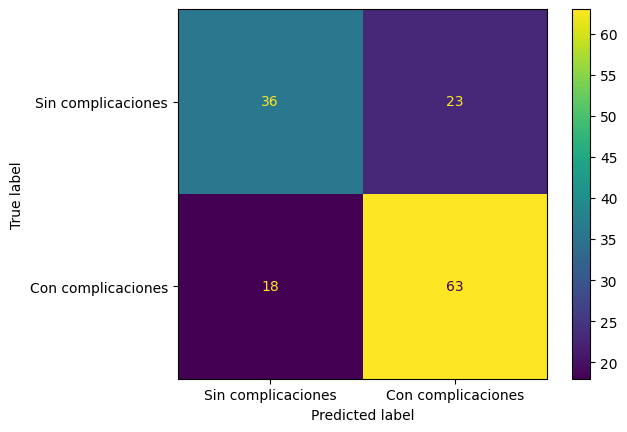

In [425]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=["Sin complicaciones", "Con complicaciones"])
plt.show()

# Interpretabilidad

In [402]:
shap.initjs()

In [426]:
explainer_lr = shap.TreeExplainer(best_dt, X_train)

In [431]:
shap_values = explainer_lr(X_train)
# shap.summary_plot(shap_values, X_train)

In [436]:
print(shap_values.values.shape)

(326, 142, 2)


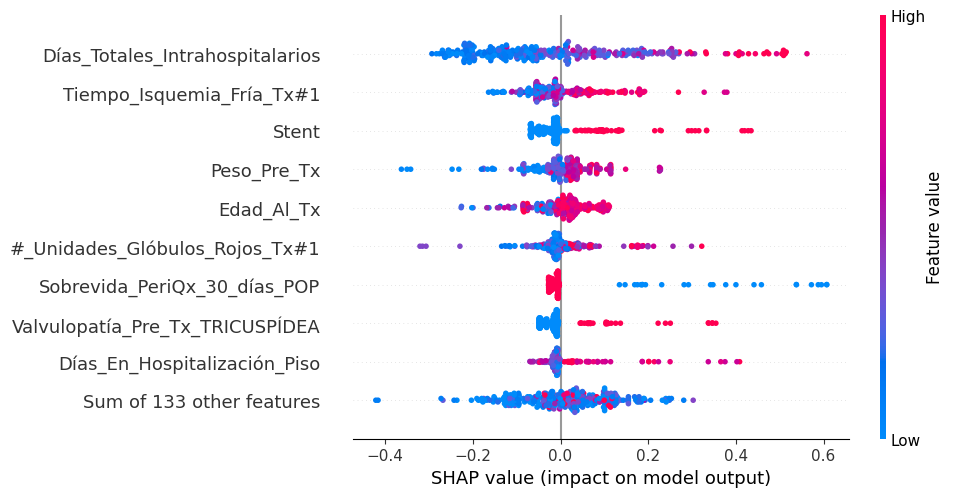

In [ ]:
# Extract SHAP values for class 1
values = shap_values.values[:, :, 1]

# Build a new Explanation object with 2D values
expl_class1 = shap.Explanation(
    values=values,
    base_values=shap_values.base_values[:, 1],
    data=shap_values.data,
    feature_names=shap_values.feature_names
)

# Beeswarm plot
shap.plots.beeswarm(expl_class1)

In [441]:
for i in X_train.columns:
    print(i)

Edad_Al_Tx
Tiempo_En_Lista_Días
Peso_Pre_Tx
MELD_Score
Edad_Donante_Tx#1
#_Unidades_Glóbulos_Rojos_Tx#1
#_Unidades_Plasma_Fresco_Congelado_Tx#1
#_Unidades_Crioprecipitados_Tx#1
#_Unidades_Plaquetas_Tx#1
Tiempo_Quirúrgico_Tx#1
Días_En_UCI
Días_En_Hospitalización_Piso
Días_Totales_Intrahospitalarios
Tiempo_Isquemia_Fría_Tx#1
Composición_Corporal
Hepatocarcinoma
Falla_Cardiaca_Pre_Tx
Antecedente_De_Tabaquismo
Antecedente_De_Alcoholismo
Enfermedad_Coronaria_Pre_Tx
Infarto_Cardiaco_Pre_Tx
Diabetes_Mellitus_Pre_Tx
Hipertensión_Arterial_Pre_Tx
CMV_Receptor
Trasplante_Combinado-Hígado-Riñón_Tx#1
Soporte_Vasopresor_PeriTx
Levosimendan_PeriTx
Noradrenalina_PeriTx
Adrenalina_PeriTx
Vasopresina_PeriTx
Dopamina_PeriTx
Amiodarona_PeriTx
Stent
Requirió_Reconstrucción_Biliar
Fast_Track
Rechazo_Agudo
Rechazo_Crónico
Retrasplante
PTLD
Sobrevida_PeriQx_30_días_POP
Es_Mujer
Causa_Tx_ADENOMA GIGANTE
Causa_Tx_ALCOHÓLICA
Causa_Tx_ATRESIA VIAS BILIARES
Causa_Tx_BUDDCHIARI
Causa_Tx_CIRROSIS BILIAR SECUNDARIA
C